In [398]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np
from models.Feature.GooLeNet import GoogLeNet

In [399]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

In [400]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [401]:
model = GoogLeNet(classes=len(class_name)).to(device)

In [402]:
model.load_state_dict(torch.load('inception_v1_cifar10_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [403]:
feature_blobs = []

In [404]:
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

In [405]:
model._modules

OrderedDict([('pre_layers', Sequential(
                (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace)
              )), ('a3', Inceptionv1(
                (branch1): Sequential(
                  (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
                  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace)
                )
                (branch2): Sequential(
                  (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
                  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace)
                  (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [406]:
model._modules.get('b5').register_forward_hook(hook_feature)

In [407]:
params = list(model.parameters())

In [408]:
class_weights = np.squeeze(params[-2].cpu().data.numpy())

In [409]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './test1.png'

img = Image.open(img_path)

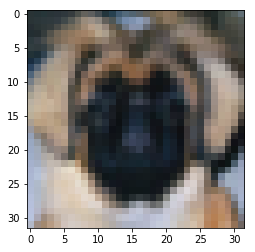

In [410]:
plt.imshow(img)

In [411]:
import torchvision.transforms as transforms

cvt_tensor = transforms.ToTensor()

tensor_img = cvt_tensor(img).to(device)

In [412]:
tensor_img = tensor_img.view(1, 3, 32, 32)

In [413]:
output = model(tensor_img)

In [414]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [415]:
h_x.sort(0, True)

torch.return_types.sort(
values=tensor([7.3704e-01, 2.3550e-01, 2.5282e-02, 1.6277e-03, 4.9582e-04, 4.0828e-05,
        1.0829e-05, 1.4364e-06, 1.2802e-06, 2.6999e-07]),
indices=tensor([5, 2, 6, 3, 4, 7, 0, 8, 9, 1]))

In [416]:
pred = h_x.argmax(0).item()
print(pred)

5


In [417]:
class_name[pred]

'dog'

In [418]:
feature_blobs[0][0].shape

(1024, 8, 8)

In [419]:
class_weights.shape

(10, 1024)

In [420]:
final_conv = feature_blobs[0][0]

In [425]:
def gen_feature_map(feature_):
    length = len(feature_)
    
    size = np.sqrt(1024)
    
    r, c = int(size), int(size)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(feature_[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("feature_%s.png" % class_name[pred])
    plt.show()
    
def min_max_scaling(cam):
    cam = (cam - np.min(cam)) / np.max(cam) - np.min(cam)
    return cam

def standard_scaling(cam):
    cam = (cam - np.mean(cam)) / np.std(cam)
    return cam

def scaling(cam):
    cam = cam - np.min(cam)
    cam /= np.max(cam)
    
    return cam

In [429]:
cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[2]):
    cam += w*final_conv[i,:,:]

In [434]:
feature_ = []

for i, w in enumerate(class_weights[4]):
    feature_.append(w*final_conv[i,:,:])

In [435]:
cnt = 0
for f in feature_:
    if np.sum(np.abs(f)) == 0:
        cnt+=1
print(cnt)

863


In [384]:
cam = scaling(cam)

In [385]:
cam

array([[0.7773168 , 0.7177582 , 0.71687806, 0.7429812 , 0.72194403,
        0.79126114, 0.81763965, 0.7925402 ],
       [0.92344606, 0.7520663 , 0.58604807, 0.58945316, 0.7303734 ,
        0.5002739 , 0.95762247, 0.8778357 ],
       [0.71709925, 0.45985228, 0.        , 0.4145114 , 0.789916  ,
        0.804086  , 0.8392002 , 0.88734704],
       [0.521752  , 0.56223756, 0.30705968, 0.40209916, 0.71761864,
        0.9868008 , 0.71243995, 0.81546474],
       [0.5708414 , 0.26376742, 0.46565348, 0.49121565, 0.63141054,
        0.7576816 , 0.90697783, 0.8364715 ],
       [0.3320327 , 0.27718812, 0.5179609 , 0.6696508 , 0.52991   ,
        0.30763486, 0.8216566 , 0.8949903 ],
       [0.6646215 , 0.52549714, 0.5488112 , 0.6465666 , 0.6166405 ,
        0.75321627, 0.98507506, 1.        ],
       [0.7700631 , 0.69206285, 0.66790974, 0.71234316, 0.58060706,
        0.6223314 , 0.6433433 , 0.5953858 ]], dtype=float32)

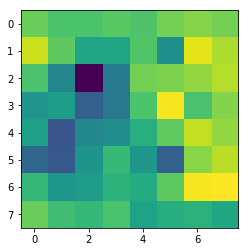

In [386]:
plt.imshow(cam)

In [387]:
import cv2

cam = cv2.resize(cam, (128, 128))

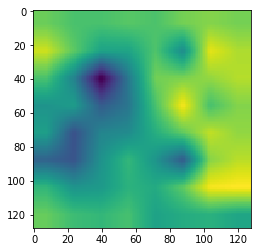

In [388]:
plt.imshow(cam)

In [389]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

In [390]:
img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))

In [391]:
img.shape

(128, 128, 3)

In [392]:
heatimg = heatmap*0.4 + img*0.5

In [393]:
cv2.imwrite('./cam.jpg', heatimg)

True

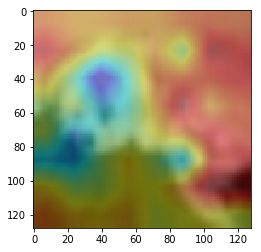

In [394]:
cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
plt.imshow(cam_img)

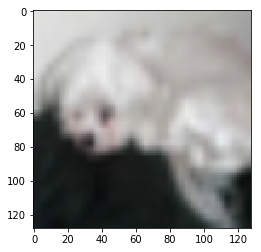

In [395]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))